# Captstone Project

#### To what extent are fraudulent job postings able to be identified amongst valid job postings on monster.com?

Expanded question: Using the dataset with set fraudulent postings as training, can those trained model(s) be used to find any fake job postings in a dataset of Monster.com postings? 

Datasets:

- https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction   - Fake Job Postings Dataset
- https://www.kaggle.com/datasets/PromptCloudHQ/us-jobs-on-monstercom  - US Monster Job Listing Dataset

Contents:
<ul><li><a href="#Data Cleaning">Data Cleaning</a></li>
<li><a href="#Modeling">Modeling</a>
<li><a href="#Results">Results</a></ul>


In [1]:
# Importing basic modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Importing balancing function
from imblearn.over_sampling import SMOTE

# Importing classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Importing evaluation matrces
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score

# Setting environment to ignore future warnings
import warnings
warnings.simplefilter('ignore')

# Loading Data

In [2]:
# Loading data using PANDAS library
df = pd.read_csv("fake_job_postings.csv", index_col=[0])
post_df = pd.read_csv("monster_com-job_sample.csv", index_col=[0])
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<div id="Data Cleaning">
    
# Data Cleaning

In [3]:
# Test dataset will be used for cleaning and post_df will be used for reference one predictions have been made
test_df = post_df.copy()

In [4]:
# lets try to check the percentage of missing values, unique values, 
# percentage of one catagory values and type against each column.
def stat_check(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum(), df[col].isnull().sum() * 100 / df.shape[0], df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Missing values', 'Percentage of Missing Values', 'Data Type'])
    stats_df.set_index('Feature', drop=True, inplace=True)
    
    # Droping features in which no NAN  is present
    stats_df.drop(stats_df[stats_df['Missing values'] == 0].index, axis=0, inplace=True)
    
    # Sorting table according to number of NAN
    stats_df.sort_values('Percentage of Missing Values', ascending=False, inplace=True)
    
    return stats_df

In [5]:
stat = stat_check(df)
stat

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,
salary_range,874,15012,83.959732,object
department,1337,11547,64.580537,object
required_education,13,8105,45.329978,object
benefits,6205,7210,40.324385,object
required_experience,7,7050,39.429530,object
function,37,6455,36.101790,object
industry,131,4903,27.421700,object
employment_type,5,3471,19.412752,object
company_profile,1709,3308,18.501119,object


In [6]:
stat2 = stat_check(test_df)
stat2

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,
date_added,78,21878,99.445455,object
salary,1737,18554,84.336364,object
organization,738,6867,31.213636,object
sector,163,5194,23.609091,object
job_type,39,1628,7.400000,object


As we can see there are some columns where more than 40% of the value is missing. We cannot fill so many missing values with random data otherwise we will lose the purity of the data so we have to drop those columns. 

In [8]:
stat_check(df)

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,
required_experience,7,7050,39.429530,object
function,37,6455,36.101790,object
industry,131,4903,27.421700,object
employment_type,5,3471,19.412752,object
company_profile,1709,3308,18.501119,object
requirements,11968,2695,15.072707,object
location,3105,346,1.935123,object
description,14801,1,0.005593,object


In [7]:
# Dropping columns where more than 40 percent values are missing
cols = stat[stat['Percentage of Missing Values'] > 40].index
df.drop(cols, axis=1, inplace=True)

cols2 = stat2[stat2['Percentage of Missing Values'] > 40].index
test_df.drop(cols2, axis=1, inplace=True)

In [9]:
stat_check(test_df)

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,
organization,738,6867,31.213636,object
sector,163,5194,23.609091,object
job_type,39,1628,7.400000,object


In [10]:
# Filling missing values with "MOST FREQUENT" value in categorical features
df.required_experience.fillna(df.required_experience.mode()[0], inplace=True)
df.function.fillna(df.function.mode()[0], inplace=True)
df.industry.fillna(df.industry.mode()[0], inplace=True)
df.employment_type.fillna(df.employment_type.mode()[0], inplace=True)

In [11]:
stat_check(df)

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,
company_profile,1709,3308,18.501119,object
requirements,11968,2695,15.072707,object
location,3105,346,1.935123,object
description,14801,1,0.005593,object


As seen above, all data types are object and there are unique values, so in this case I will go with the most frequent value of that feature to replace the null values in those columns.

In [12]:
# Dropping remaining missing values
df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [13]:
stat_check(df)

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,


Some of the features above are very essential to our dataset. Like requirements of the job and description that we'll be breaking down further later on. So, I'll be dropping missing values from those features instead of just filling them in.

In [14]:
stat_check(test_df)

,Unique_values,Missing values,Percentage of Missing Values,Data Type
Feature,,,,


All essential text features are concatenated into a single column.

In [15]:
# Merging all text features into a single feature
df['info'] = df.title.apply(str) + ' ' + df.description.apply(str) + ' ' + df.requirements.apply(str) + ' ' + \
             df.company_profile.apply(str) + ' ' + df.required_experience.apply(str)

test_df['info'] = test_df.job_title.apply(str) + ' ' + test_df.job_description.apply(str) 

# Dropping separate columns
df.drop(['title', 'description', 'requirements', 'company_profile', 'required_experience'], axis=1, inplace=True)
test_df.drop(['job_title', 'job_description'], axis=1, inplace=True)

In [16]:
display(df.columns)
display(test_df.columns)

Index(['location', 'telecommuting', 'has_company_logo', 'has_questions',
       'employment_type', 'industry', 'function', 'fraudulent', 'info'],
      dtype='object')

Index(['country_code', 'has_expired', 'job_board', 'job_type', 'location',
       'organization', 'page_url', 'sector', 'uniq_id', 'info'],
      dtype='object')

In [17]:
df.head(1)

,location,telecommuting,has_company_logo,has_questions,employment_type,industry,function,fraudulent,info
job_id,,,,,,,,,
1,"US, NY, New York",0,1,0,Other,Information Technology and Services,Marketing,0,"Marketing Intern Food52, a fast-growing, James..."


In [18]:
test_df.head(1)

,country_code,has_expired,job_board,job_type,location,organization,page_url,sector,uniq_id,info
country,,,,,,,,,,
United States of America,US,No,jobs.monster.com,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783,Engineer - Quality Job in Dixon Why Join Altec...


Non-essential columns will be dropped so train and test data from separate datasets will be more alike. Once similar columns are kept, job_type, and location will be changed. lastly, column names will be changed so there will be no issue in using either dataset for testing.

In [19]:
train_df = df.filter(['info','location','employment_type','industry','function','fraudulent'])
train_df = train_df.reset_index(drop=True)
train_df['id'] = 0
train_df.head(1)

,info,location,employment_type,industry,function,fraudulent,id
0,"Marketing Intern Food52, a fast-growing, James...","US, NY, New York",Other,Information Technology and Services,Marketing,0,0


In [20]:
id_data = test_df.uniq_id
test_df = test_df.filter(['info', 'location', 'job_type', 'sector', 'organization'])

# Fraud column for test df so column shape will match training df
test_df['fraudulent'] = 0
test_df['id'] = id_data
test_df = test_df.reset_index(drop=True)
test_df.head(1)

,info,location,job_type,sector,organization,fraudulent,id
0,Engineer - Quality Job in Dixon Why Join Altec...,"Dixon, CA",Full Time,Experienced (Non-Manager),Altec Industries,0,58435fcab804439efdcaa7ecca0fd783


In [21]:
train_df.employment_type.value_counts()

Full-time    10459
Contract      1181
Part-time      548
Temporary      167
Other          147
Name: employment_type, dtype: int64

In [22]:
# Multiple titles in test df will be changed to more standard job type format to match training df
test_df.loc[test_df['job_type'].str.contains('Seasonal'), 'job_type'] = 'Temporary'
test_df.loc[test_df['job_type'].str.contains('Full'), 'job_type'] = 'Full-time'
test_df.loc[test_df['job_type'].str.contains('Part'), 'job_type'] = 'Part-time'
test_df.loc[test_df['job_type'].str.contains('Contract'), 'job_type'] = 'Contract'
test_df.loc[test_df['job_type'].str.contains('Full'), 'job_type'] = 'Full-Time'
test_df.loc[test_df['job_type'].str.contains('Diem'), 'job_type'] = 'Other'
test_df.loc[test_df['job_type'].str.contains('Exempt'), 'job_type'] = 'Other'
test_df.loc[test_df['job_type'].str.contains('Employee'), 'job_type'] = 'Other'

In [23]:
test_df.job_type.value_counts()

Full-Time    10994
Part-time      582
Contract       162
Other          108
Temporary        1
Name: job_type, dtype: int64

In [25]:
import re
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')

def plot_wordcloud(text):
    from wordcloud import WordCloud

    comment_words = ''
    stopwords = list(nltk.corpus.stopwords.words('english'))

    # Iterate through the csv file, typecast to string, and split 
    for val in text:
        val = str(val)
        tokens = val.split()
        
        # Set tokens to lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words = comment_words + ' '.join(tokens)+ ' '
    
    # Set wordcloud settings
    wordcloud = WordCloud(width = 1400, height = 800, background_color ='black', colormap='Set3', collocations=False,
          stopwords = stopwords,
          min_font_size = 10).generate(comment_words)

    # Plot the WordCloud image
    plt.figure(figsize = (10, 5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

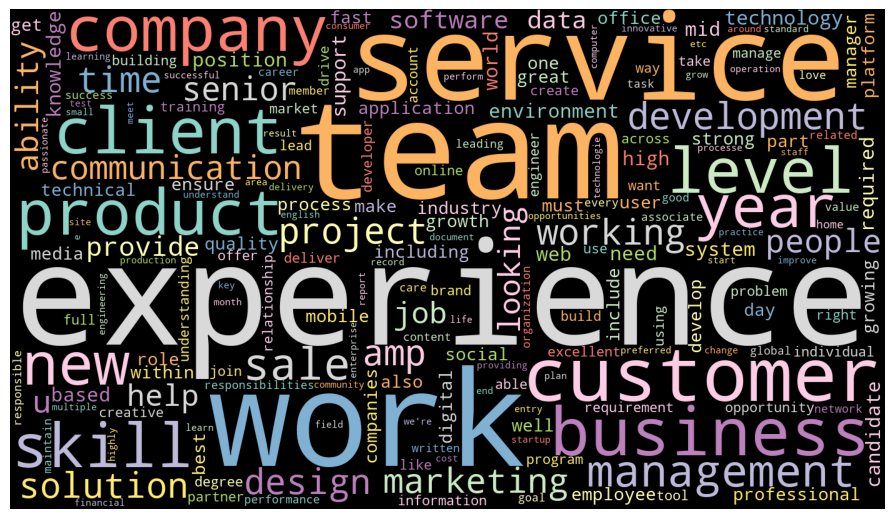

In [25]:
plot_wordcloud(train_df[train_df['fraudulent'] == 0]['info'])

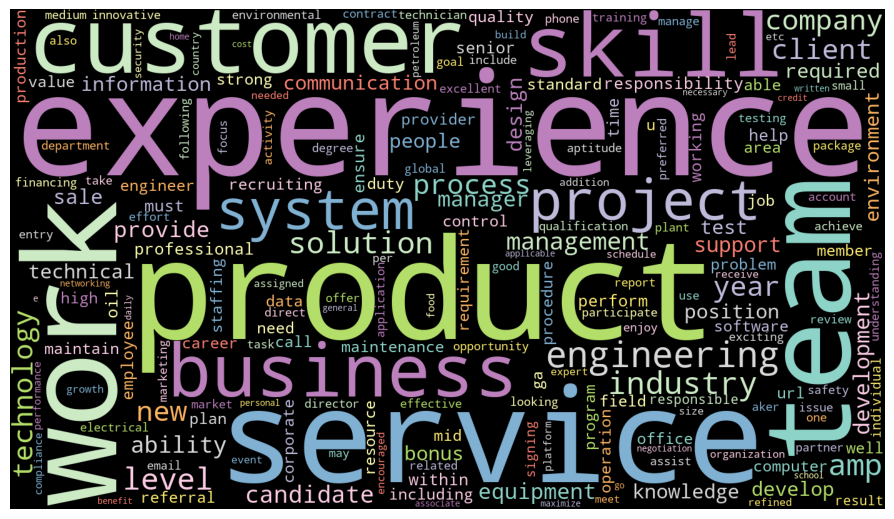

In [78]:
plot_wordcloud(train_df[train_df['fraudulent'] == 1]['info'])

<hr>
The following plots show the most common words in both fraud and non-fraud postings.
The first plot that I made is for the jobs that are not fraudulent and second is for fraudulent.

Non-Fraudulent Common Words:
- Service
- Team
- Customer
- Experience
- Work
- Company/Business

Fraudulent Common Words:
- Experience 
- Work 
- Customer 
- Product 
- Service

In [188]:
# Common words to be compared to Monster.com dataset later
nf_words = ['service', 'team', 'customer', 'experience', 'work', 'company', 'business']
f_words = ['experience', 'work', 'customer', 'product', 'service', 'sale', 'team']

In [26]:
# Separates City/State of location and splits to two location columns
train_df['location_1'] = train_df.location.str.split(', ').apply(lambda x: x[0])
train_df['location_2'] = train_df.location.str.split(', ').apply(lambda x: x[2] if len(x)>1 else x[0])

train_df.drop('location', axis=1, inplace=True)

In [27]:
test_df['location_1'] = test_df.location.str.split(',').apply(lambda x: (x[1])[0:3] if len(x)>1 else x[0])
test_df['location_2'] = test_df.location.str.split(', ').apply(lambda x: x[0])

test_df.drop('location', axis=1, inplace=True)

Location columns for both datasets have multiple values, city/state/zipcode(sometimes), so, I have extracted the city/state into two different location columns.

In [28]:
import nltk
STOPWORDS = nltk.corpus.stopwords.words('english') 
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_data(txt):
    
    # Set to lowercase
    txt = txt.lower()                             
    # Remove Links
    txt = re.sub(r'https?:\/\/\S+', '', txt)      
    # Remove Newline
    txt = re.sub(r'\n', ' ', txt)                 
    # Remove all special characters
    txt = re.sub(r'[^a-zA-Z0-9]',' ', txt)
    # Drop all stop words and will lemmatize each of the word to get the base word
    txt = " ".join([lemmatizer.lemmatize(i) for i in txt.split() if i not in STOPWORDS])
    
    return txt

In [29]:
# Apply cleaning function on data
train_df['info'] = train_df['info'].apply(clean_data)
test_df['info'] = test_df['info'].apply(clean_data)

In [30]:
# Rename columns in test df to match training df
test_df.rename(columns={'job_type':'employment_type', \
                       'sector':'industry', \
                       'organization':'function'}, inplace=True)

In [31]:
test_df.head(1)

,info,employment_type,industry,function,fraudulent,id,location_1,location_2
0,engineer quality job dixon join altec consider...,Full-Time,Experienced (Non-Manager),Altec Industries,0,58435fcab804439efdcaa7ecca0fd783,CA,Dixon


In [32]:
train_df.head(1)

,info,employment_type,industry,function,fraudulent,id,location_1,location_2
0,marketing intern food52 fast growing james bea...,Other,Information Technology and Services,Marketing,0,0,US,New York


In [33]:
# Encoding categorical features
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cols = ['employment_type', 'industry', 'function', 'location_1', 'location_2']

for i in cols:
    train_df[i] = encoder.fit_transform(train_df[i])
    test_df[i] = encoder.fit_transform(test_df[i])

After cleaning texts for both datasets, I encoded categorical features into numerical values using label encoder from a sklearn library. 

Encoding is necessary because machine learning algorithms can only work with numeric data. They can not work with categorical as actual data, that's why I also have to vectorize our text into numeric values, so that we can feed those values to the model to make prediction.

In [34]:
display(train_df.head(2))
display(test_df.head(2))

,info,employment_type,industry,function,fraudulent,id,location_1,location_2
0,marketing intern food52 fast growing james bea...,2,57,22,0,0,74,1058
1,customer service cloud video production organi...,1,73,7,0,0,53,109


,info,employment_type,industry,function,fraudulent,id,location_1,location_2
0,engineer quality job dixon join altec consider...,1,34,88,0,58435fcab804439efdcaa7ecca0fd783,17,723
1,shift supervisor part time job camphill positi...,1,91,510,0,64d0272dc8496abfd9523a8df63c184c,86,432


In [35]:
# Vectorizing text data to add "weight" to words used in text data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(train_df['info'])

vec = vectorizer.transform(train_df['info']).toarray()
train_vec = pd.DataFrame(data=vec, columns=vectorizer.get_feature_names())

vectorizer.fit(test_df['info'])
vec2 = vectorizer.transform(test_df['info']).toarray()
test_vec = pd.DataFrame(data=vec2, columns=vectorizer.get_feature_names())

In [36]:
# Adding other features to vector data
cols = ['employment_type', 'industry', 'function', 'fraudulent', 'location_1', 'location_2', 'id']
for i in cols:
    train_vec[i] = train_df[i].values
    test_vec[i] = test_df[i].values

In [37]:
print(test_vec.shape)
print(train_vec.shape)

(11847, 5004)
(12502, 5004)


<div id="Modeling">

# Modeling

In [38]:
# Setting variables for datasets with and without fraudulent column
X = train_vec.drop('fraudulent', axis=1)
y = train_vec.fraudulent

X2 = test_vec.drop('fraudulent', axis=1)
X2.id = 0
y2 = test_vec.fraudulent

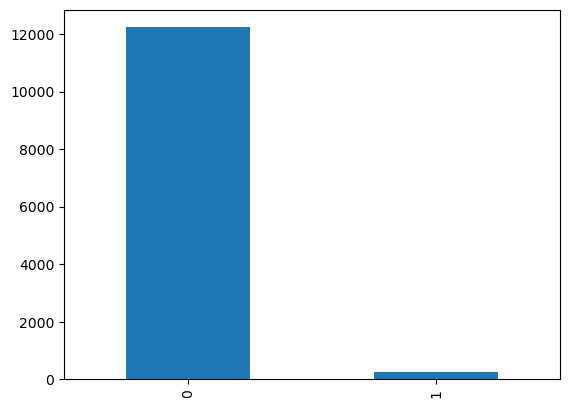

In [39]:
y.value_counts().plot(kind='bar')
plt.show()

In [40]:
print('Percentage of fraudulent jobs: {0:.0%}'.format(sum(train_df.fraudulent==1)/(len(train_df))))

Percentage of fraudulent jobs: 2%


Here we see a big problem with the training dataset. While it technically does have fraudulent posts, there aren't many of them. The non-fraudulent far outweight the fraudulent. This is an imbalanced dataset. 

So, I'm going to use Smote to balance the dataset by making duplicate fraudulent data, that's only slightly different, so training will be more thorough. A perfect solution would be to have a well balanced dataset, but I work with what I have.

In [41]:
# Balancing data

sampler = SMOTE()
X, y = sampler.fit_resample(X, y)

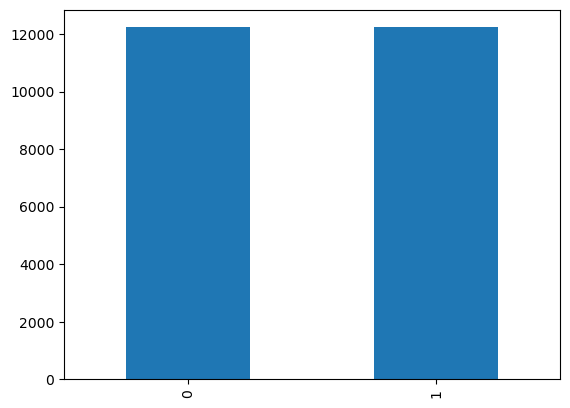

In [42]:
y.value_counts().plot(kind="bar")
plt.show()

Now the training data can be split into training and testing sets.

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [44]:
# Trains and tests a model
# Calls the MC_test function to get p-value
# Reshuffles train/test data through model if p-value < 0.05 to verify if it consistantly falls below
def tt_model(m):

    count = 0
    loop = True
    
    while loop:
        
        # Sets train and test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        print('Test ', count+1, ':')
        
        # Trains model
        m.fit(X_train, y_train)
        # Tests model
        m_pred = m.predict(X_test)
        # Gets data from confusion matrix and feeds to MC_test function for p-value
        con_m = confusion_matrix(y_test, m_pred)
        mat_scores = tuple(con_m[0]), tuple(con_m[1])
        loop = MC_test(mat_scores)

        if loop:
            count = count + 1
        
        # Stops loop if p-value < 0.05 more than 10 times
        if count >= 10:
            return model_scores(X_test, y_test, m_pred, m)
    
    # Feeds test and model data to model_score function to print 
    #    accuracy, precision, recall, and confusion matrix chart report
    return model_scores(X_test, y_test, m_pred, m)

In [227]:
# McNemars code courtesy of https://towardsdatascience.com/have-you-ever-evaluated-your-model-in-this-way-a6a599a2f89c
# Author: Sergen Cansiz
# Returns bool to tt_model function
from scipy import stats

def MC_test(tup):
    # Confusion matrix:  [ [a, b] , [c , d] ]
    cm = np.array(tup)

    # McNemars Statistic 
    MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

    # Degree of freedom (n-1)*(k-1)
    dof = (len(cm[0])-1) * (len(cm[1])-1)

    # Obtain p-value from Chi-Sqaure Distribution
    r1 = 1- stats.chi2.cdf(MCStatistic , dof)
    r2 = stats.distrubution.chi2.sf(MCstatistic, dof)
    
    r_val = True

    # Sets r1 to false to rerun loop in tt_model function if p-value < 0.05
    if r1 > 0.05:
        print('Null hypothesis can not be rejected')
        print('There is not significant difference - p value : {:.2f}%'.format(r1*100))
        print('')
        print('_'*50)
        r_val = False
    else:
        print('Null hypothesis rejected')
        print('There is significant difference - p value : {:.2f}%'.format(r1*100))
        r_val = True
        print('')
        print('_'*50)
        
    return r_val

In [204]:
def model_scores(xdata, ydata, pred, clf):
# Prints Accuracy, Precision, Recall, F1, and Matrix scores
# Plots matrix data

    # Accuracy
    accuracy = accuracy_score(ydata, pred)
    # AUC
    ac = roc_auc_score(ydata, pred)
    # Precision
    precision = precision_score(ydata, pred, average=None)
    # Recall
    recall = recall_score(ydata, pred, average=None)
    # F1 Score
    f1_sco = f1_score(ydata, pred, average=None)
    # Confusion Matrix
    confusion_mat = confusion_matrix(ydata, pred)
    # Report
    report = classification_report(ydata, pred)

    # Printing all details
    print('Accuracy : ', accuracy)   
    print("-"*50)
    print('AUC Score : ', ac)   
    print("-"*50)
    print('F1 : ', f1_sco)
    print("-"*50)
    print('Reacll : ', recall)
    print("-"*50)
    print('Precision : ', precision)
    print("-"*50)
    print('Confusion Matrix....\n', confusion_mat)
    print("-"*50)
    print('Classification Report....\n', report)
    print("-"*50)
    print('Plotting Confusion Matrix...\n')
    plot_confusion_matrix(clf, xdata, ydata)
    plt.show()
    

#### Running Models

Test  1 :
Null hypothesis can not be rejected
There is not significant difference - p value : 6.33%
Accuracy :  0.9933251600599373
--------------------------------------------------
AUC Score :  0.9933239508084727
--------------------------------------------------
F1 :  [0.99330875 0.99334149]
--------------------------------------------------
Reacll :  [0.99154853 0.99509937]
--------------------------------------------------
Precision :  [0.99507524 0.9915898 ]
--------------------------------------------------
Confusion Matrix....
 [[3637   31]
 [  18 3655]]
--------------------------------------------------
Classification Report....
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3668
           1       0.99      1.00      0.99      3673

    accuracy                           0.99      7341
   macro avg       0.99      0.99      0.99      7341
weighted avg       0.99      0.99      0.99      7341

---------------------------

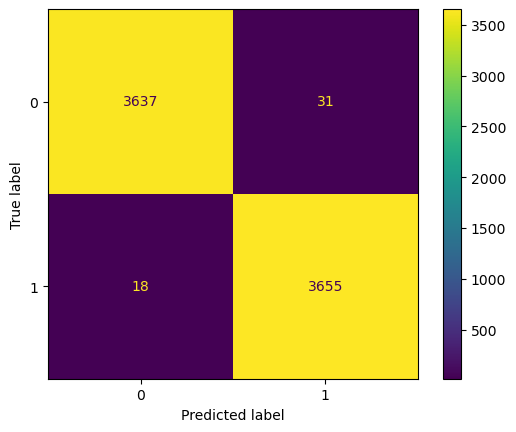

In [62]:
# Sets model and runs train/test function
tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
tt_model(tree)

Test  1 :
Null hypothesis can not be rejected
There is not significant difference - p value : 8.33%

__________________________________________________
Accuracy :  0.9995913363302003
--------------------------------------------------
AUC Score :  0.9995847176079734
--------------------------------------------------
F1 :  [0.99958455 0.99959791]
--------------------------------------------------
Reacll :  [0.99916944 1.        ]
--------------------------------------------------
Precision :  [1.         0.99919614]
--------------------------------------------------
Confusion Matrix....
 [[3609    3]
 [   0 3729]]
--------------------------------------------------
Classification Report....
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3612
           1       1.00      1.00      1.00      3729

    accuracy                           1.00      7341
   macro avg       1.00      1.00      1.00      7341
weighted avg       1.00      1

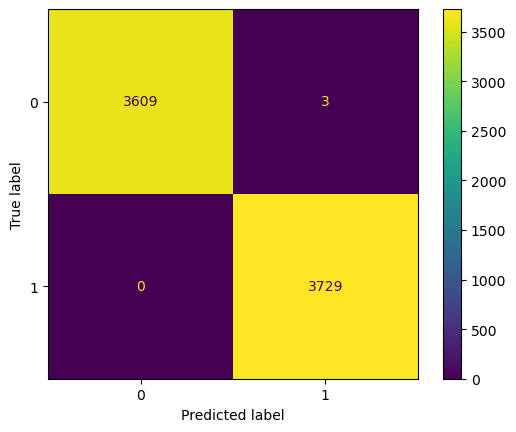

In [256]:
log = LogisticRegression(C=100, solver='liblinear', max_iter=2000)
tt_model(log)

Test  1 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  2 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  3 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  4 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  5 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  6 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  7 :
Null hypothesis rejected
There is significant difference - p value : 0.00%

__________________________________________________
Test  8 :
Null hypothesis rejected
There 

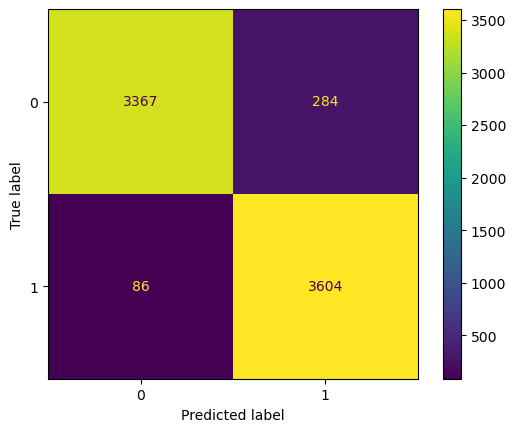

In [258]:
knn = KNeighborsClassifier(n_neighbors=5)
tt_model(knn)

For the decision tree and logistic regression model, all the accuracy/precision/recall scores are over 95% with p-values > 0.05. Unfortunately, the k-nearest neighbors model consistently had a p-value under 1% and the precision for predicting positive classes was less than 95% resulting in 284 false positives.

In [201]:
from sklearn.feature_extraction.text import CountVectorizer
import enchant

# Uses count vectorizer on job descriptions for either fraudulent or non-fraudulent to find count of common words
# Returns top 20 words to bar_chart function if list_type is single
# Returns count of top common words (f_words/nf_words) to bar_chart function if list_type is multi
def word_count(text2, fraud, list_type):
    
    l_holder = []
    ldata = ''
    
    # Sets list ldata to fraud/non-fraud common words
    if fraud == True:
        ldata = f_words
    else:
        ldata = nf_words

    # Gets common word count of job descriptions as dict
    # Filters out non-english words
    vecc = CountVectorizer()
    bow = vecc.fit_transform(text2)
    bag_list = bow.sum(axis=0) 
    w_list = [(word, bag_list[0, idx]) for word, idx in vecc.vocabulary_.items()]
    w_list = dict(w_list)
    d = enchant.Dict("en_US")
    key_list = list(w_list.keys())
    
    # Deletes dict entries that contain digits as keys
    for i in key_list:
        if d.check(i) == False:
            del w_list[i]
        elif i.isdigit() == True:
            del w_list[i]
            
    # Sorts dict and saves top 20 common words/count
    if list_type == 'single':        
        w_list = dict(sorted(w_list.items(), key=lambda x:x[1], reverse=True))
        l_holder = dict(list(w_list.items())[0:20])
    
    # Saves count from dict values for fraud/non-fraud words in ldata
    elif list_type == 'multi':
        for i in ldata:
            if i in w_list.keys():
                l_holder.append(w_list[i])
            else:
                print(i, ' not in dict')

    # Returns data to bar_chart function to create chart
    return l_holder

In [250]:
# Creates top 20 bar chart or multi bar chart depending on list_type (single or multi)
# Calls job_check function to get list of all fraud/non-fraud job descriptions
# Calls word_count function to get word count of common words using list from job_check function
def bar_chart(p, fraud, list_type):
    
    l, title, color = '', '', ''
    if list_type == 'single':

        # Set the color and title for fraud and non-fraud charts
        if fraud == True:
            title = 'Common Fraudulent Words'
            color = 'maroon'
        else:
            title = 'Common Non-fraudulent Words'
            color = 'green'

        # Set x,y data using job_check & word_count function to get common words and counts
        dic_data = word_count(job_check(p, fraud), fraud, list_type)
        x = dic_data.keys()
        y = dic_data.values()
        
        # Bar plot
        figure(figsize=(10, 3))
        plt.xticks(rotation=45, ha='right')
        plt.bar(x,y, color=color)
        plt.title(title)
        plt.ylabel('Word Count')
        plt.xlabel('Common Words')
        
    elif list_type == 'multi':
        
        # Set title and list of words to search for
        if fraud == True:
            l = f_words
            title = 'Common Fraudulent Words'
        else:
            l = nf_words
            title = 'Common Non-fraudulent Words'
        
        # Set x,y data for multi bar plot
        y = word_count(job_check(p[0], fraud), fraud, list_type)
        y1 = word_count(job_check(p[1], fraud), fraud, list_type)
        X = np.arange(len(l))
        
        # Multi bar plot
        figure(figsize=(10, 3))
        plt.bar(X + 0.00, y, color = 'teal', width = 0.25, label='Logistic Regression')
        plt.bar(X + 0.25, y1, color = 'purple', width = 0.25, label='Decision Tree')
        plt.ylabel('Word Count')
        plt.xlabel('Common Words')
        plt.title(title)
        plt.xticks(X + 0.17, l)
        plt.legend()

In [ ]:
# Print positive fraud posts using id and original monster.com dataset - post_df
def job_check(p, fraud):
    
    if fraud == True:
        num = 1
    else:
        num = 0
    
    # Assigns prediction array from model to 'fraudulent' column in test_df dataframe
    test_df.fraudulent = p
    # Gathers job ID from all fraud/non-fraud jobs
    fraud_id = test_df[test_df['fraudulent'] == num]['id']

    data_holder, new_df = [], []

    # Get job descriptions from original Monster.com dataset using job IDs
    for i in fraud_id:           
        data_holder=chdf[chdf['uniq_id'] == str(i)]['job_description'][0]  
        new_df.append(data_holder)

        
    return list(new_df)

In [239]:
# Save models with p-value > 0.05
import pickle

saved_lin_model = pickle.dumps(log)
saved_tree_model = pickle.dumps(tree)


In [240]:
# Load models
log_load = pickle.loads(saved_lin_model)
tree_load = pickle.loads(saved_tree_model)


In [241]:
# Make prediction based on Monster.com dataset (without fradulent column - X2)
pred = log_load.predict(X2)
pred2 = tree_load.predict(X2)


<div id="Results">

# Results

In [242]:
print('Decision Tree:')
print('Positive fraudulent posts: ', sum(pred2 == 1))
print('Non-Fraudulent posts: ', sum(pred2 == 0))
print('-'*50)
print('Logistic Regression:')
print('Positive fraudulent posts: ', sum(pred == 1))
print('Non-Fraudulent posts: ', sum(pred == 0))

Decision Tree:
Positive fraudulent posts:  226
Non-Fraudulent posts:  11621
--------------------------------------------------
Logistic Regression:
Positive fraudulent posts:  33
Non-Fraudulent posts:  11814


In [54]:
# Clean original Monster.com job description data
chdf = post_df.copy()
chdf['job_description'] = chdf['job_description'].apply(clean_data)

In [55]:
chdf['job_description'] = chdf['job_description'].str.replace('beacon','')
chdf['job_description'] = chdf['job_description'].str.replace('hill','')

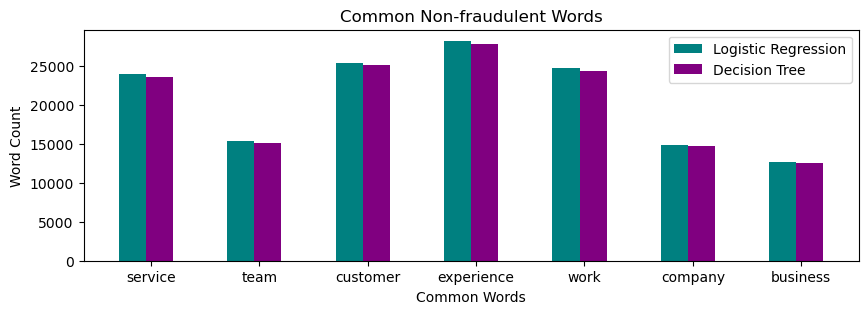

In [251]:
bar_chart([pred,pred2], False, 'multi')

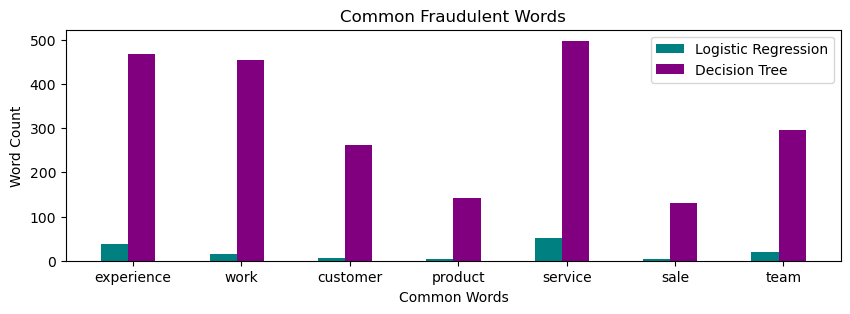

In [252]:
bar_chart([pred,pred2], True, 'multi')

#### Decision Tree Model - Common Words

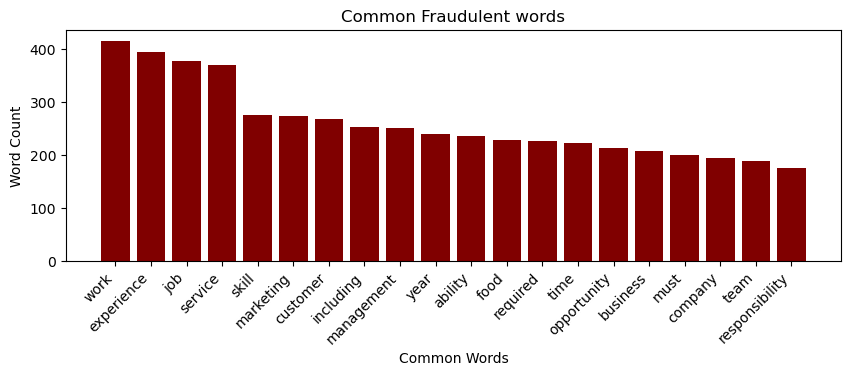

In [79]:
bar_chart(pred2, True, 'single')

#### Logistic Regression Model - Common Words

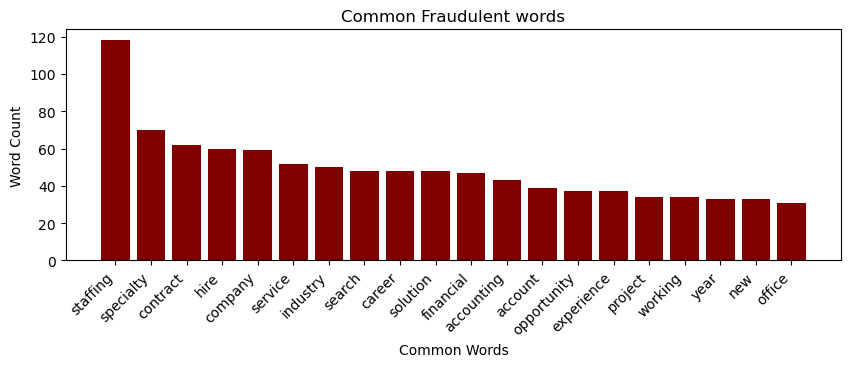

In [248]:
bar_chart(pred, True, 'single')